<a href="https://colab.research.google.com/github/arslansevval/BreastCancerClassificationwithKNN/blob/master/Breast_Cancer_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
# Scikit-Learn ≥0.20 is required
import sklearn
#assert sklearn.__version__ >= "0.20"
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis, LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
# Common imports
import numpy as np
import pandas as pd

# To plot pretty figures
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Load the data
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data.csv")
data.drop(['Unnamed: 32', 'id'], inplace = True, axis = 1)
data = data.rename(columns = {"diagnosis" :"target" })
data["target"] = [1 if i.strip() == "M" else 0 for i in data.target]
print(data.head(10))

   target  radius_mean  ...  symmetry_worst  fractal_dimension_worst
0       1        17.99  ...          0.4601                  0.11890
1       1        20.57  ...          0.2750                  0.08902
2       1        19.69  ...          0.3613                  0.08758
3       1        11.42  ...          0.6638                  0.17300
4       1        20.29  ...          0.2364                  0.07678
5       1        12.45  ...          0.3985                  0.12440
6       1        18.25  ...          0.3063                  0.08368
7       1        13.71  ...          0.3196                  0.11510
8       1        13.00  ...          0.4378                  0.10720
9       1        12.46  ...          0.4366                  0.20750

[10 rows x 31 columns]


In [5]:
data.isnull().values.any()
#missing value:none

False

0    357
1    212
Name: target, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


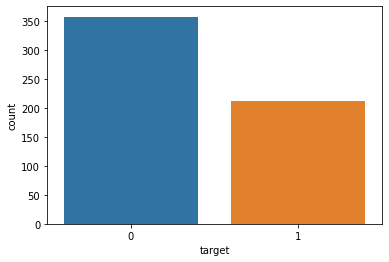

In [6]:
sns.countplot(data["target"])
print(data.target.value_counts())

In [7]:
print(len(data))

569


In [8]:
print("Data Shape", data.shape)

Data Shape (569, 31)


In [9]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   target                   569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [10]:
data.describe()

,target,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


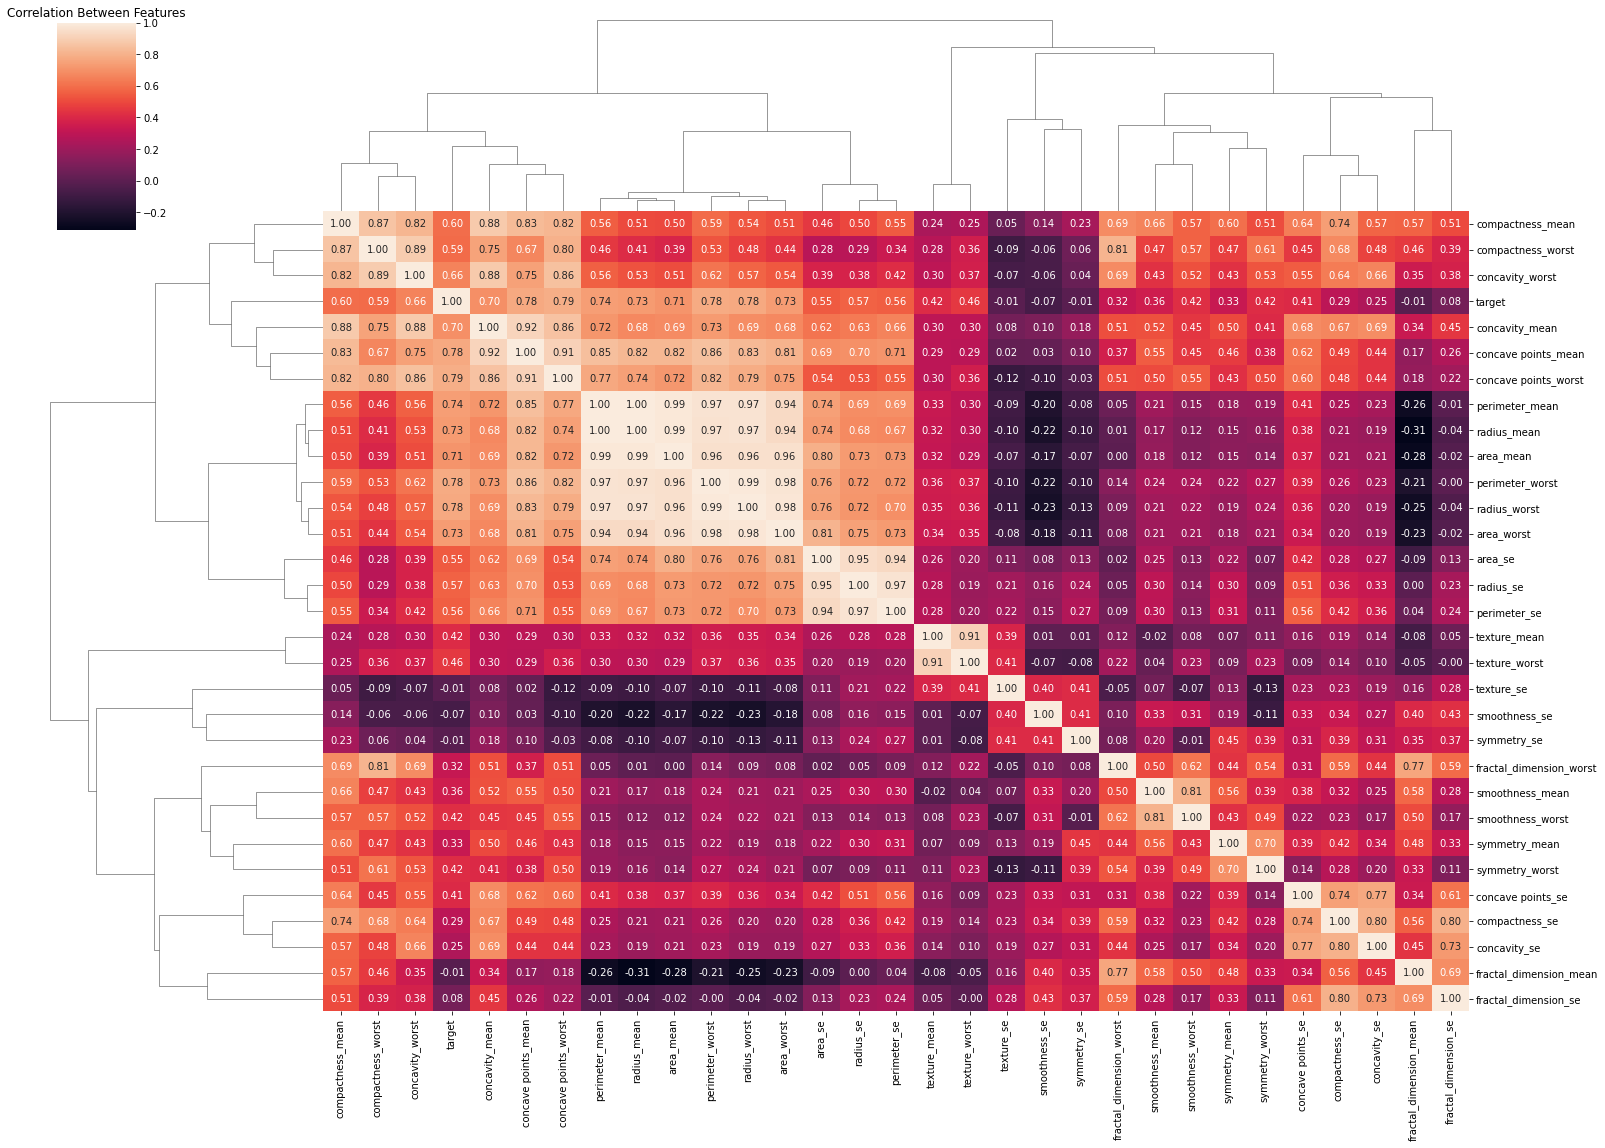

'plt.figure(figsize=(22,16))\nsns.heatmap(corr_matrix, \n            xticklabels=corr_matrix.columns.values,\n            yticklabels=corr_matrix.columns.values,\n            linewidth= 0.2,\n            linecolor = \'black\',\n            annot = True,\n            cmap="YlGnBu",\n            )'

In [11]:
#Explore data analysis
#Correlation
corr_matrix = data.corr()
sns.clustermap(corr_matrix, annot = True, fmt = ".2f", figsize=(22,16))
plt.title("Correlation Between Features")
plt.show()
"""plt.figure(figsize=(22,16))
sns.heatmap(corr_matrix, 
            xticklabels=corr_matrix.columns.values,
            yticklabels=corr_matrix.columns.values,
            linewidth= 0.2,
            linecolor = 'black',
            annot = True,
            cmap="YlGnBu",
            )"""


Text(0.5, 1.0, 'Correlation Between Features w corr threshold 0.75')

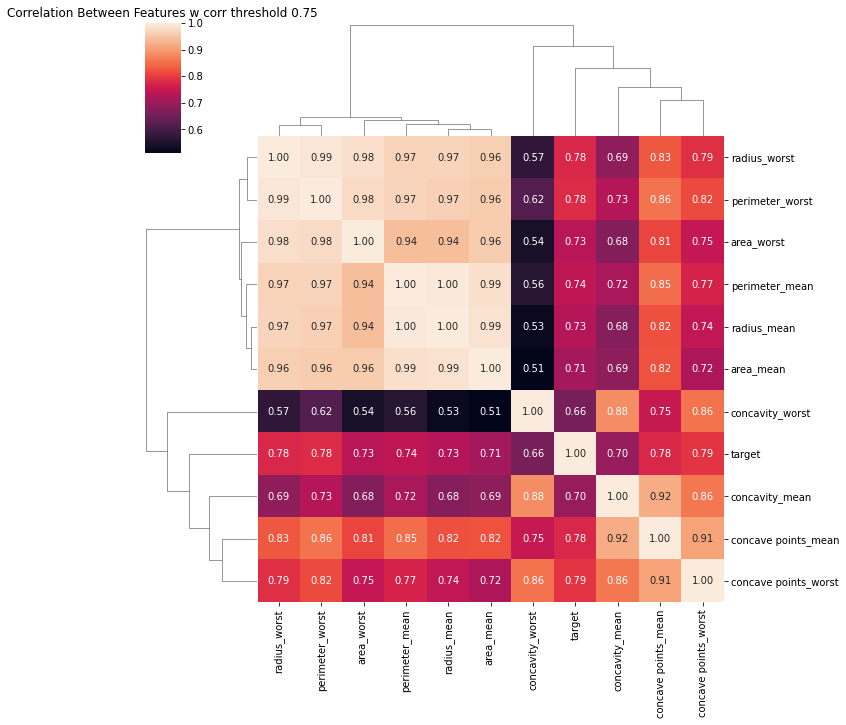

In [12]:
#there some correlated features
threshold = 0.60
filtre = np.abs(corr_matrix["target"]) > threshold
corr_features = corr_matrix.columns[filtre].tolist()
sns.clustermap(data[corr_features].corr(), annot = True, fmt = ".2f")
plt.title("Correlation Between Features w corr threshold 0.75")

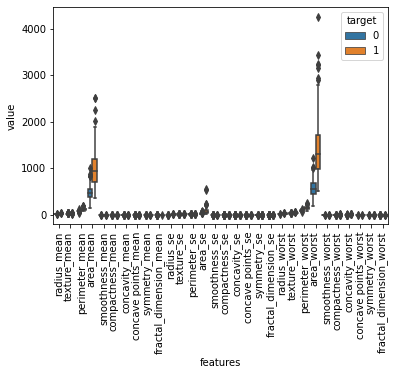

'\nstandartization-normalization\n'

In [13]:
#box plot
data_melted = pd.melt(data, id_vars = "target", 
                      var_name = "features",
                      value_name = "value")
plt.figure()
sns.boxplot(x = "features", y= "value", hue = "target", data = data_melted)
plt.xticks(rotation = 90)
plt.show()
"""
standartization-normalization
"""

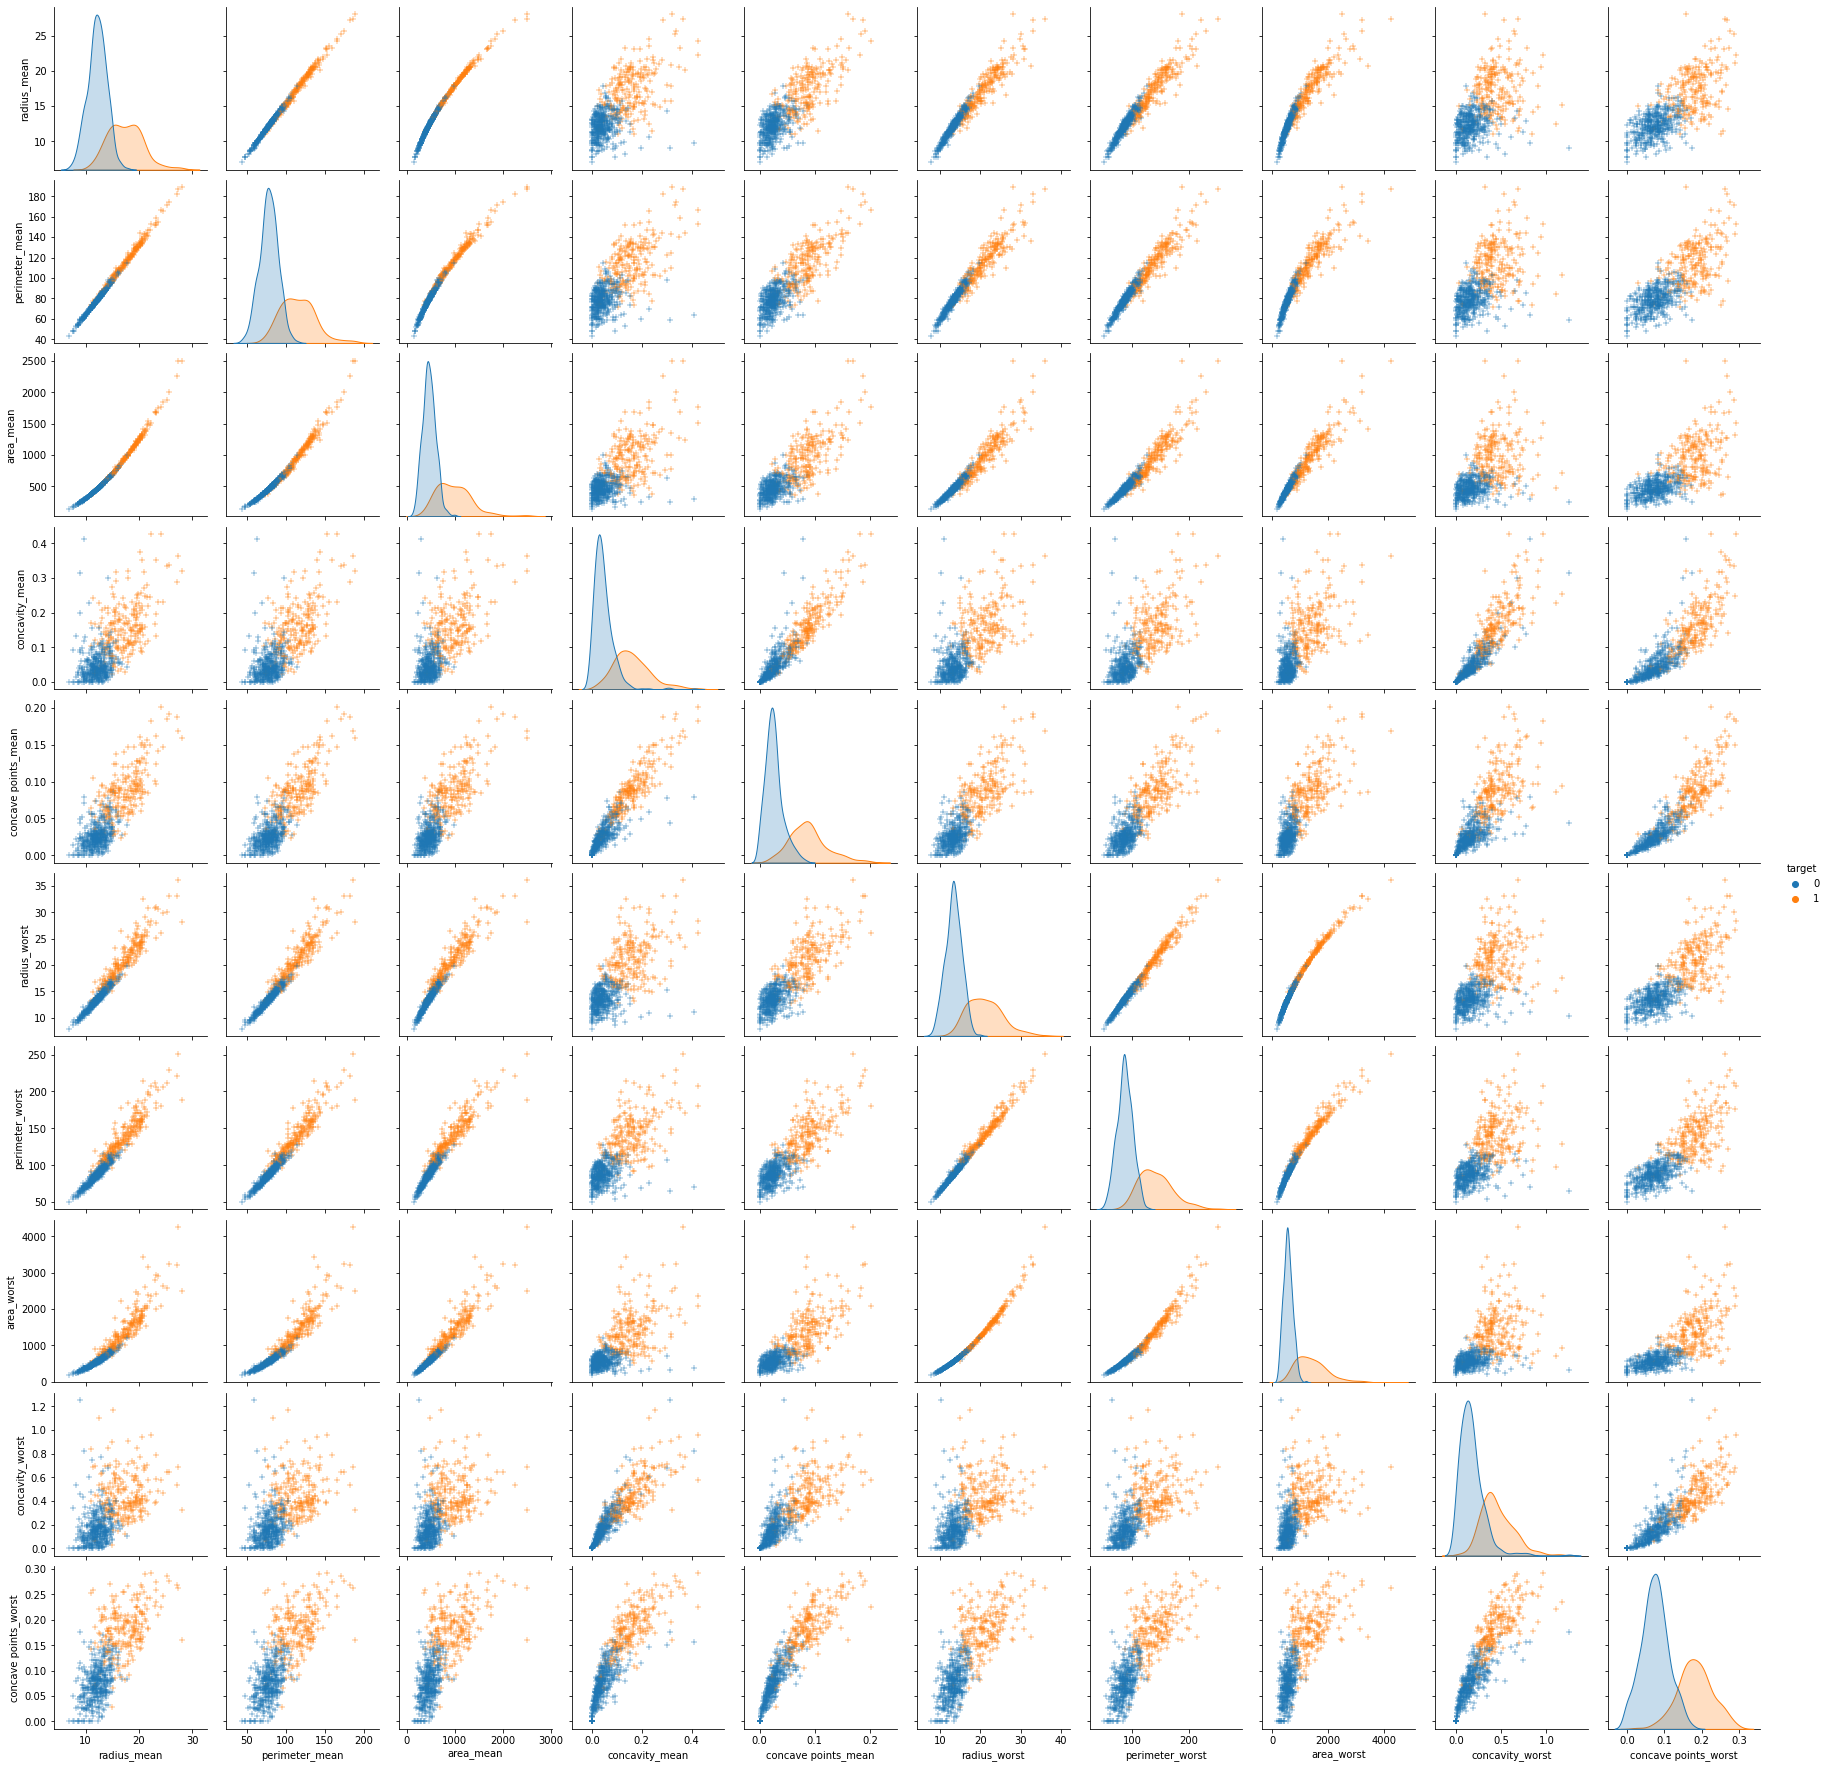

In [14]:
#pair plot
sns.pairplot(data[corr_features], diag_kind = "kde", markers = "+", hue = "target")
plt.show()
#skewness var

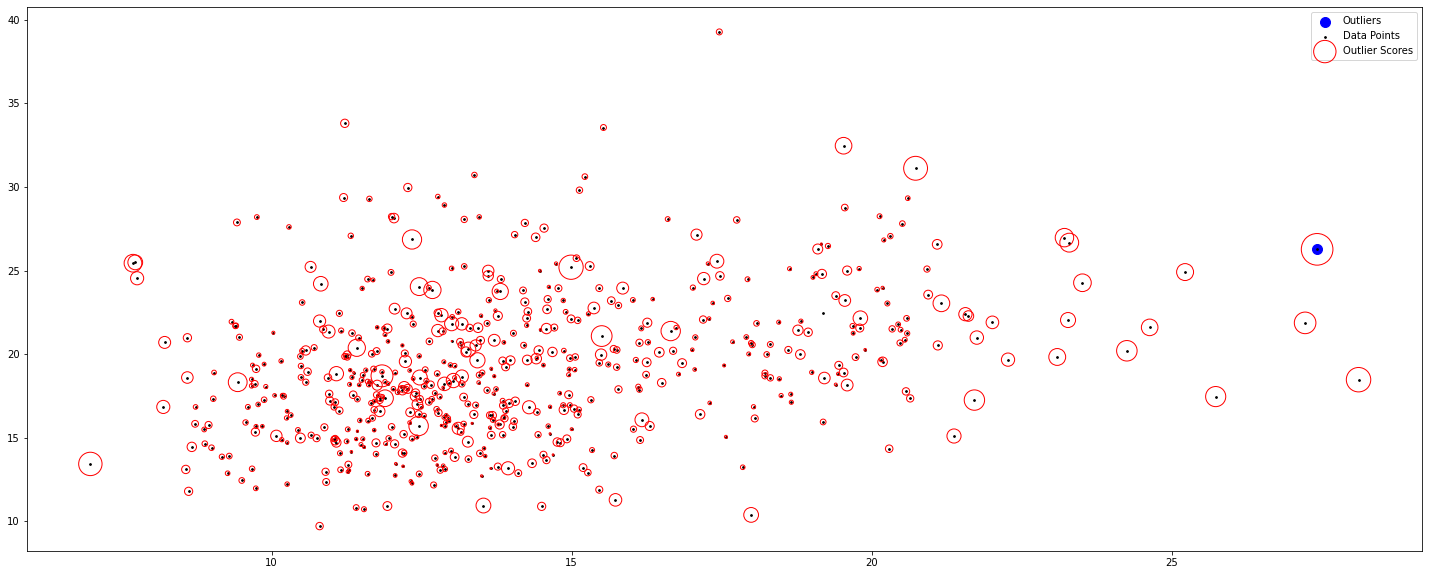

In [15]:
#Density based Outlier Detection System
#--->Local Outlier Factor
#local density of one point to local density of its KNN 
y = data["target"]
x = data.drop(["target"], axis = 1)
columns = x.columns.tolist()

clf = LocalOutlierFactor()
y_pred = clf.fit_predict(x)
X_score = clf.negative_outlier_factor_

outlier_score = pd.DataFrame()
outlier_score["score"] = X_score

#threshold
threshold = -2.5
filtre = outlier_score["score"] < threshold
outlier_index = outlier_score[filtre].index.tolist()

#plt.scatter
plt.figure(figsize=(25,10))
plt.scatter(x.iloc[outlier_index,0],x.iloc[outlier_index,1], color = "blue", s= 100, label = "Outliers" )
plt.scatter(x.iloc[:,0],x.iloc[:,1], color = "k", s= 3, label = "Data Points" )
radius = (X_score.max() - X_score)/(X_score.max() - X_score.min())
outlier_score["radius"] = radius
plt.scatter(x.iloc[:,0],x.iloc[:,1], edgecolors = "r",facecolors = "none", s= 1000*radius, label = "Outlier Scores")
plt.legend()
plt.show()

#drop outliers
x = x.drop(outlier_index)
y = y.drop(outlier_index).values


In [16]:
#Train Test Split
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.3, random_state = 42) 

In [24]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_df = pd.DataFrame(X_train, columns = columns)
X_train_df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02,3.970000e+02
mean,8.948901e-18,3.369821e-17,-2.600774e-17,-2.181295e-17,5.593063e-19,-2.572809e-17,-1.705884e-17,1.230474e-17,1.398266e-18,5.872716e-18,9.508207e-18,-1.677919e-18,6.152369e-18,3.915144e-18,2.516878e-18,1.174543e-17,-2.852462e-17,1.398266e-17,5.033757e-18,9.787860e-18,-6.152369e-18,-1.454196e-17,-6.432023e-18,-1.258439e-17,-2.824497e-17,-1.118613e-18,6.432023e-18,-3.383803e-17,1.957572e-18,-1.118613e-17
std,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00,1.001262e+00
min,-1.712388e+00,-2.175361e+00,-1.632924e+00,-1.303791e+00,-2.404872e+00,-1.638974e+00,-1.126020e+00,-1.291511e+00,-2.340956e+00,-1.731378e+00,-1.087167e+00,-1.594208e+00,-1.076887e+00,-7.786835e-01,-1.400632e+00,-1.264283e+00,-1.053454e+00,-1.910582e+00,-1.517866e+00,-1.036680e+00,-1.554165e+00,-2.165353e+00,-1.558852e+00,-1.163524e+00,-2.217924e+00,-1.426295e+00,-1.351626e+00,-1.782104e+00,-2.098683e+00,-1.623010e+00
25%,-7.039450e-01,-7.291157e-01,-7.065592e-01,-6.765379e-01,-7.086599e-01,-7.677983e-01,-7.505222e-01,-7.462174e-01,-6.923019e-01,-7.154003e-01,-6.238305e-01,-7.008680e-01,-6.076433e-01,-5.188333e-01,-6.296877e-01,-6.806452e-01,-5.438890e-01,-6.470712e-01,-6.604475e-01,-5.475440e-01,-6.821946e-01,-7.528643e-01,-7.019438e-01,-6.578384e-01,-7.527979e-01,-6.715073e-01,-7.547935e-01,-7.847938e-01,-6.687460e-01,-6.938485e-01
50%,-2.446426e-01,-1.109439e-01,-2.549616e-01,-2.989145e-01,-9.870612e-02,-2.500035e-01,-3.559314e-01,-3.888829e-01,-3.575803e-02,-1.774476e-01,-2.821900e-01,-1.886966e-01,-2.787104e-01,-3.466753e-01,-2.082721e-01,-2.690774e-01,-2.138530e-01,-1.341452e-01,-2.255425e-01,-2.392287e-01,-2.715302e-01,-5.708877e-02,-2.809144e-01,-3.430225e-01,-4.097822e-02,-2.830139e-01,-2.487165e-01,-2.253839e-01,-1.273445e-01,-2.398587e-01
75%,4.919745e-01,5.648931e-01,5.336490e-01,3.852569e-01,6.086412e-01,5.418139e-01,4.663710e-01,6.740944e-01,5.587789e-01,4.845408e-01,2.935375e-01,4.860540e-01,2.594032e-01,1.399420e-01,3.380665e-01,3.285568e-01,2.849132e-01,4.243920e-01,3.101924e-01,2.279157e-01,4.880926e-01,6.757303e-01,5.339215e-01,2.884427e-01,6.097035e-01,5.982844e-01,5.947450e-01,7.322025e-01,4.793437e-01,4.494271e-01
max,4.033514e+00,4.645288e+00,4.063861e+00,5.327298e+00,4.767417e+00,4.097233e+00,4.417475e+00,4.049923e+00,4.490747e+00,4.845302e+00,9.189961e+00,4.583425e+00,9.830837e+00,1.170270e+01,7.693190e+00,6.131052e+00,1.230997e+01,6.537894e+00,4.990888e+00,9.364540e+00,3.590418e+00,3.877586e+00,3.782128e+00,4.325859e+00,3.771406e+00,4.615614e+00,3.461489e+00,2.511223e+00,5.979346e+00,5.130159e+00


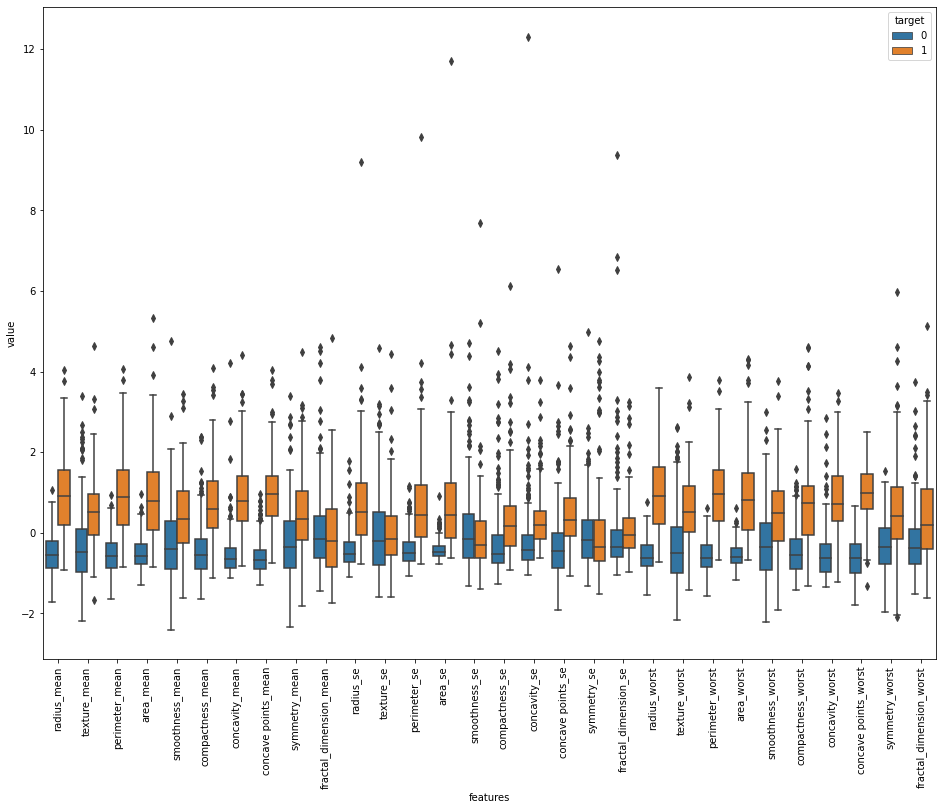

In [28]:
X_train_df_describe = X_train_df.describe()
X_train_df["target"] = Y_train 
#box plot
data_melted = pd.melt(X_train_df, id_vars = "target", 
                      var_name = "features",
                      value_name = "value")
plt.figure(figsize=(16,12))
sns.boxplot(x = "features", y= "value", hue = "target", data = data_melted)
plt.xticks(rotation = 90)
plt.show()

In [41]:
#### Basic K-Nearest Neighbour Classifier
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)
y_pred = knn.predict(X_test)
cm = confusion_matrix(Y_test, y_pred)
acc = accuracy_score(Y_test, y_pred)
score = knn.score(X_test, Y_test)
print("Score: ", score)
print("Confusion Matrix:\n ", cm)
print("Basic KNN Accuracy: ", acc)

Score:  0.9590643274853801
Confusion Matrix:
  [[105   4]
 [  3  59]]
Basic KNN Accuracy:  0.9590643274853801


In [79]:
#### Random Forest Classifier

#Initializing the model
model1 = RandomForestClassifier(n_estimators=25)
#Fitting the model for the train data
model1.fit(X_train, Y_train)
#Predicting for the unseen/test data
predict1 = model1.predict(X_test)
#Calculating the accuracy of the model
accuracy_score(Y_test, predict1)

0.9707602339181286

In [80]:
#precision and recall determined by comparing predictions results tothe actual classification of each predicted observation
prec_rec = classification_report(predict1, Y_test)
print(prec_rec)

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       110
           1       0.95      0.97      0.96        61

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171

